In [7]:
import pandas as pd
import geopandas as gpd

In [1]:
from dgfip.read import get_structures
structures = get_structures()

# Variables disponibles

In [3]:
structures.columns

Index(['Nomenclature interne', 'TYPE DE SERVICE', 'LIBELLE DU SERVICE',
       'NOM DU SERVICE', 'DEPARTEMENT', 'ADRESSE', 'BP', 'CODE POSTAL',
       'COMMUNE', 'CODE COMMUNE', 'COURRIEL', 'HORAIRES 1', 'ACCUEIL SUR RDV',
       'geocodage', 'Type de démarche', 'TELEPHONE 1', 'TELEPHONE 2',
       'Nom Officiel Département', 'Code Officiel Région',
       'Nom Officiel Région', 'public', 'service', 'Code Courant Officiel',
       'Nom Officiel Commune', 'dep_code_de_geocodage'],
      dtype='object')

# Horaires

In [4]:
structures['HORAIRES 1']

0                               SANS RDV L MA J V 8H30-12H
1                                        SEULEMENT SUR RDV
2                                          TLJ  8H45-12H45
3                                TOUS LES MATINS  8H30-12H
4                              DU LUNDI AU VENDREDI 9H-12H
                               ...                        
17827    Voir sur le site https://agence-cohesion-terri...
17828    Voir sur le site https://agence-cohesion-terri...
17829                                  Mercredi 8H30 12H00
17830                                 Mercredi\n8H30 11H30
17831                                    Vendredi 8H30 12H
Name: HORAIRES 1, Length: 17832, dtype: object

In [6]:
# fond de carte des départements
dep = gpd.read_file('https://github.com/gregoiredavid/france-geojson/raw/master/departements-version-simplifiee.geojson', crs='4236')

In [3]:
count = structures.groupby(['DEPARTEMENT','TYPE DE SERVICE'], as_index=False).size()

In [4]:
count

,DEPARTEMENT,TYPE DE SERVICE,size
0,01,Buralistes,124
1,01,Centre de Finances publiques,20
2,01,France Services,19
3,01,Permanences finances publiques,2
4,02,Buralistes,122
...,...,...,...
333,94,France Services,12
334,95,Buralistes,140
335,95,Centre de Finances publiques,21
336,95,France Services,15


In [5]:
tot = count[count['TYPE DE SERVICE'] != 'Buralistes'].groupby('DEPARTEMENT').sum().reset_index()
tot['TYPE DE SERVICE'] = 'Non Buralistes'

In [8]:
base = pd.concat((count, tot[['DEPARTEMENT', 'TYPE DE SERVICE', 'size']]))

In [9]:
# import de la population française
population = pd.read_csv('../data/ensemble/Departements.csv', sep=";")

In [10]:
count_norm = base.merge(population, left_on='DEPARTEMENT', right_on="CODDEP")
count_norm['par_hab'] = count_norm['size']/count_norm['PTOT']*10000

In [17]:
base = count_norm[['DEPARTEMENT','TYPE DE SERVICE', 'par_hab','size']]

In [19]:
base.to_csv('../data/dep_count.csv')

In [52]:
data = dep.merge(count_norm, left_on = 'code', right_on = 'DEPARTEMENT')

In [53]:
base = data[['code', 'nom','geometry', 'TYPE DE SERVICE', 'par_hab']]

In [55]:
base.to_file('../data/count_departement.geojson',driver="GeoJSON")

/home/titouan/projects/OptimisationFiscale/.venv/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Géocodage

In [11]:
from collections import Counter
ct = Counter(structures['geocodage'].apply(type))
ct.most_common()

[(str, 17645), (float, 187)]

In [12]:
# exemple structures mal géocodées
pb_geo = structures[structures.geocodage.apply(lambda s : isinstance(s, float))]

<AxesSubplot:>

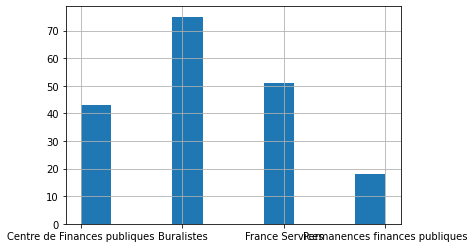

In [13]:
# quels types de structure ?
pb_geo['TYPE DE SERVICE'].hist()